In [1]:
%matplotlib inline
from scipy.io import *
import numpy as np
import matplotlib.pyplot as plt
import sys
from dave import DAVE
from scipy.ndimage.filters import gaussian_filter

In [2]:
s = np.load('Q:\\data\\20110225\\sdo.x766y1118.20110225.npz')
data = np.transpose(np.float32(s['hmi']),(1,2,0))
k = 127

In [3]:
q = DAVE(data,(3.,3.,5.), "lusol", 10).run()

In [4]:
x = q.get()

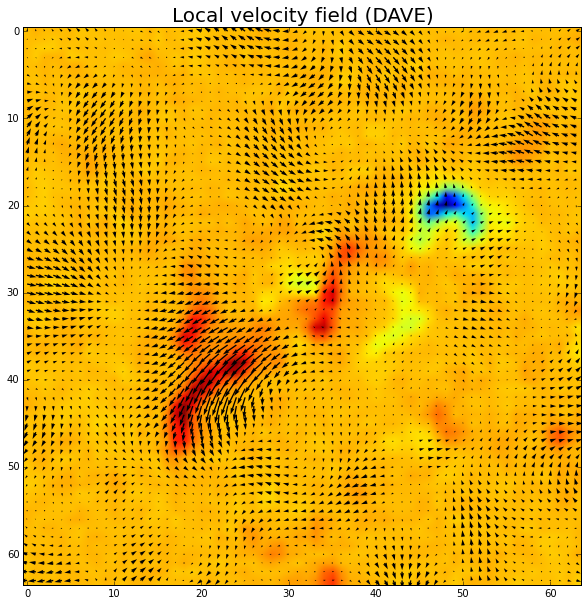

In [5]:
plt.figure(figsize = (10,10))
plt.title('Local velocity field (DAVE)', size = 20)
plt.imshow(data[:,:,k])
plt.quiver(-x[1][:,:,k], x[0][:,:,k])

In [6]:
sys.path.append('Q:\\python\\lib')
from pyfield import *

dim = data.shape[0:2]+(64,)

B1 = np.gradient(-PField(data[:,:,k], 64))

idx = np.indices(dim).astype(np.float32)  
X = np.zeros(dim+(4,), dtype = np.float32)
B = np.zeros(dim+(4,), dtype = np.float32)
#V = np.zeros(data.shape+(8,), dtype = np.float32)

X[:,:,:,0] = idx[0,:,:,:] - dim[0]/2
X[:,:,:,1] = idx[1,:,:,:] - dim[1]/2
X[:,:,:,2] = idx[2,:,:,:] - dim[2]/2
X[:,:,:,3] = 1.



#for i in range(0,64):
#    X[:,:,i,0] += x[0][:,:,k]*np.exp(-i/32.)
#    X[:,:,i,1] += x[1][:,:,k]*np.exp(-i/32.)

B[:,:,:,0] = B1[0]
B[:,:,:,1] = B1[1]
B[:,:,:,2] = B1[2]


In [7]:
sys.path.append('Q:\\python\\opencl-rotB')
from window import *
import rotB

def update(X, time, step):
    u = np.floor(X[:,:,0,0]).astype(np.int)
    v = np.floor(X[:,:,0,1]).astype(np.int)
    
    X[:,:,0,0] += x[0][u,v,np.int(np.floor(k+time))]*step
    X[:,:,0,1] += x[1][u,v,np.int(np.floor(k+time))]*step


cle = rotB.Integrator(X, B, update = update, maxiter = 1e4)
cle.start()
    
#window(cle, video_dir = '/video')

In [7]:
cle.stop()

0.104261382319


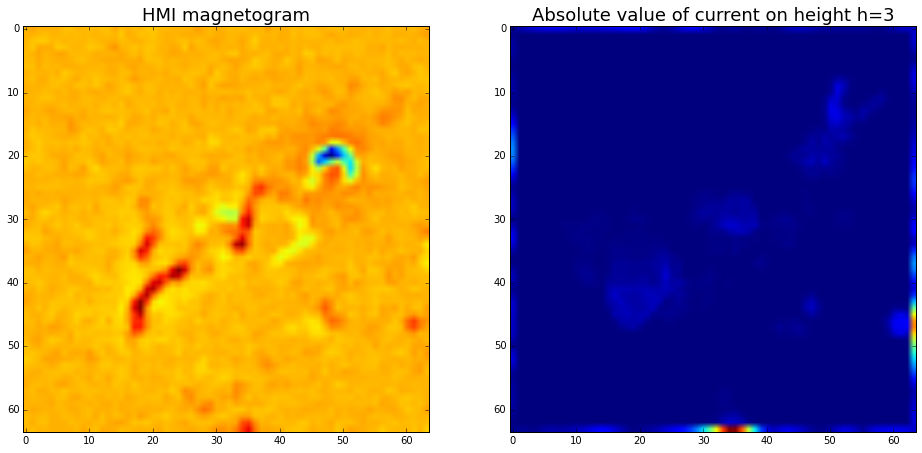

In [20]:
print cle.time
plt.figure(figsize = (16,8))
#plt.imshow(cle._Current[:,:,4,1])
plt.subplot(121)
plt.title('HMI magnetogram', size = 18)
plt.imshow(B[:,:,0,2])
plt.subplot(122)
plt.title('Absolute value of current on height h=3', size = 18)
plt.imshow(np.sqrt(np.sum(cle._Current[:,:,3,:]**2,axis=2)))

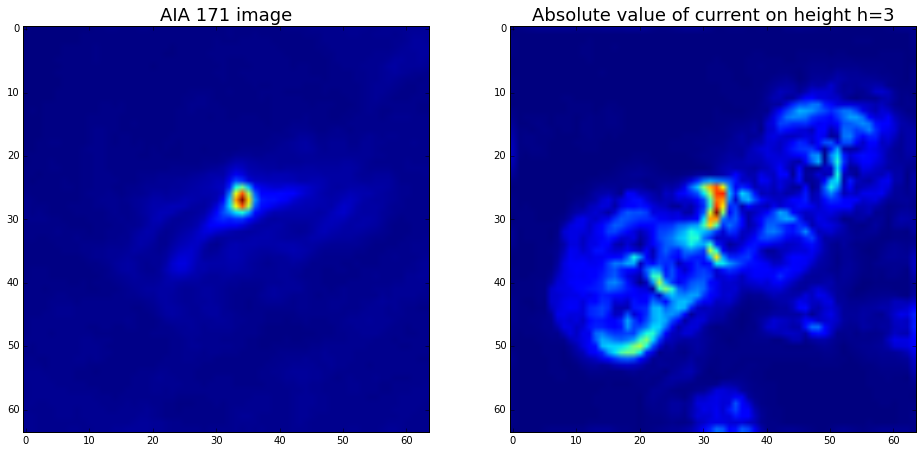

In [62]:
temp = s['aia_171'][500,:,:]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('AIA 171 image', size = 18)
plt.imshow(temp)
plt.subplot(122)
plt.title('Absolute value of current on height h=3', size = 18)
plt.imshow(np.sqrt(np.sum(cle._Current[:,:,3,:]**2,axis=2)))